In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/root/venv/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# EDA

## Variable Visualization

### Quantitative: Funding vs Primary # of Votes

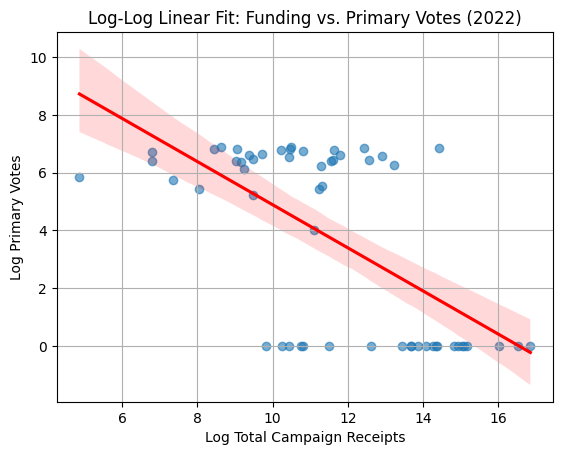

In [2]:
df_finance = pd.read_csv('candidate_summary_2022.csv')
df_dem = pd.read_csv('dem_candidates 2022.csv')
df_rep = pd.read_csv('rep_candidates 2022.csv')

df_votes = pd.concat([df_dem, df_rep], ignore_index=True)
df_finance['Cand_Name'] = df_finance['Cand_Name'].str.upper().str.strip()
df_votes['Candidate'] = df_votes['Candidate'].str.upper().str.strip()
df_votes['Primary Votes'] = pd.to_numeric(df_votes['Primary Votes'], errors='coerce')
top_vote_candidates = df_votes.sort_values(by='Primary Votes', ascending=False).dropna(subset=['Primary Votes']).head(200)
finance_names = df_finance[df_finance['Total_Receipt'] > 0]['Cand_Name'].dropna().unique()

matches = []
for name in top_vote_candidates['Candidate'].unique():
    match = process.extractOne(name, finance_names, scorer=fuzz.token_sort_ratio)
    if match and match[1] > 90:
        matches.append((name, match[0], match[1]))

matched_df = pd.DataFrame(matches, columns=['Vote_Candidate', 'Finance_Candidate', 'Match_Score'])
df_merged = pd.merge(matched_df, df_finance[['Cand_Name', 'Total_Receipt']], 
                     left_on='Finance_Candidate', right_on='Cand_Name', how='left')
df_merged = pd.merge(df_merged, df_votes[['Candidate', 'Primary Votes']], 
                     left_on='Vote_Candidate', right_on='Candidate', how='left')
final_result = df_merged[['Vote_Candidate', 'Total_Receipt', 'Primary Votes']].rename(
    columns={'Vote_Candidate': 'Candidate Name'})
final_result = final_result.dropna(subset=['Total_Receipt', 'Primary Votes'])
final_result = final_result[(final_result['Total_Receipt'] > 0) & (final_result['Primary Votes'] > 0)]

final_result

log_receipts = np.log(final_result['Total_Receipt'])
log_votes = np.log(final_result['Primary Votes'])

sns.regplot(x=log_receipts, y=log_votes, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Log-Log Linear Fit: Funding vs. Primary Votes (2022)')
plt.xlabel('Log Total Campaign Receipts')
plt.ylabel('Log Primary Votes')
plt.grid(True)
plt.show()

### Quantitative: Total Receipts vs Disbursements

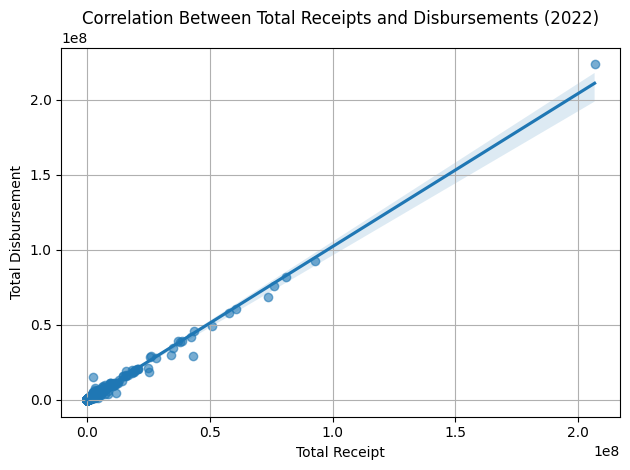

In [3]:
df = pd.read_csv("candidate_summary_2022.csv")

df["Total_Receipt"] = pd.to_numeric(df["Total_Receipt"], errors='coerce')
df["Total_Disbursement"] = pd.to_numeric(df["Total_Disbursement"], errors='coerce')
filtered_df = df[~((df["Total_Receipt"].fillna(0) == 0) & (df["Total_Disbursement"].fillna(0) == 0))]

sns.regplot(data=filtered_df, x="Total_Receipt", y="Total_Disbursement", scatter_kws={'alpha':0.6})
plt.title("Correlation Between Total Receipts and Disbursements (2022)")
plt.xlabel("Total Receipt")
plt.ylabel("Total Disbursement")
plt.grid(True)
plt.tight_layout()
plt.show()


### Qualitative: # of Democratic Candidates by Outcome: Endorsed vs. Not Endorsed

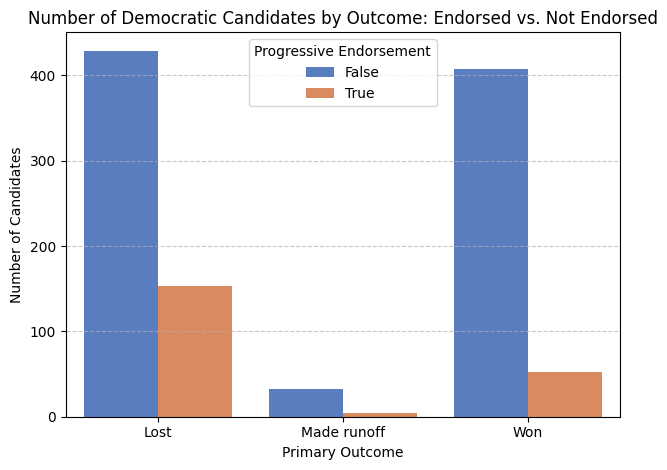

In [4]:
progressive_orgs = ['Justice Dems', 'Our Revolution', 'Sunrise', 'Indivisible', 'PCCC', 'AOC', 'Sanders' ]
df_dem['progressive'] = df_dem[progressive_orgs].notna().any(axis=1)
df_dem['Primary Votes'] = pd.to_numeric(df_dem['Primary Votes'].replace(',', '', regex=True), errors='coerce')
df_clean = df_dem.dropna(subset=['Primary Outcome'])

sns.countplot(data=df_clean, x='Primary Outcome', hue='progressive', palette='muted')

plt.title('Number of Democratic Candidates by Outcome: Endorsed vs. Not Endorsed')
plt.xlabel('Primary Outcome')
plt.ylabel('Number of Candidates')
plt.legend(title='Progressive Endorsement')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Qualitative: # of Republican Candidates by Outcome: Endorsed vs. Not Endorsed

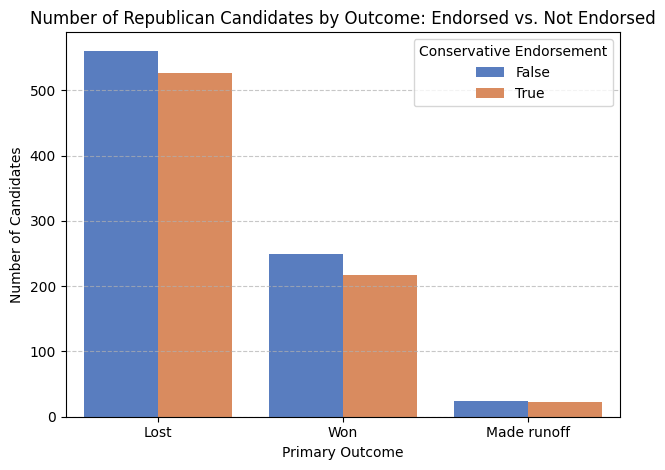

In [5]:
conservative_orgs = ['Trump', 'Club for Growth', 'Renew America', 'E-PAC', "Maggie's List", 'Winning for Women']
df_rep['conservative'] = df_rep[conservative_orgs].notna().any(axis=1)
df_rep['Primary Votes'] = pd.to_numeric(df_rep['Primary Votes'].replace(',', '', regex=True), errors='coerce')
df_clean = df_rep.dropna(subset=['Primary Outcome'])


sns.countplot(data=df_clean, x='Primary Outcome', hue='conservative', palette='muted')

plt.title('Number of Republican Candidates by Outcome: Endorsed vs. Not Endorsed')
plt.xlabel('Primary Outcome')
plt.ylabel('Number of Candidates')
plt.legend(title='Conservative Endorsement')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Inference & Decisions

## Causal Inference (using propensity score matching) 

Are candidates with the most funding more likely to receive endorsements?

In [6]:
import pandas as pd
import re
import numpy as np

#dataframes
summary = pd.read_csv("candidate_summary_2022.csv")
dems = pd.read_csv("dem_candidates 2022.csv")
reps = pd.read_csv("rep_candidates 2022.csv")
candidates = pd.concat([dems, reps], ignore_index=True)

#functions
def clean_last_first(name):
    if pd.isna(name):
        return ''
    parts = name.lower().split(',')
    if len(parts) == 2:
        last, first = parts[0].strip(), parts[1].strip()
        return re.sub(r'[^a-z]', '', first + last)
    return re.sub(r'[^a-z]', '', name.lower())

def clean_first_last(name):
    if pd.isna(name):
        return ''
    parts = name.lower().split()
    if len(parts) >= 2:
        first, last = parts[0], parts[-1]
        return re.sub(r'[^a-z]', '', first + last)
    return re.sub(r'[^a-z]', '', name.lower())

#clean name
candidates['name_clean'] = candidates['Candidate'].apply(clean_first_last)
summary['name_clean'] = summary['Cand_Name'].apply(clean_last_first)

df = pd.merge(candidates, summary, on='name_clean', how='inner')

#endorsements
endorsement_cols = ["EMILY's List", "Justice Dems", "Indivisible", "PCCC", "Our Revolution", "Sunrise",
    "Sanders", "AOC", "Party Committee", "Trump", "Club for Growth",
    "Renew America", "E-PAC", "VIEW PAC", "Maggie's List", "Winning for Women"]
df['endorsement_count'] = df[endorsement_cols].apply(lambda row: (row == 'Yes').sum(), axis=1)
df['endorsed'] = (df['endorsement_count'] > 0).astype(int)

#funding
df['funding'] = pd.to_numeric(df['Total_Receipt'], errors='coerce')
df = df[df['funding'].notna() & df['funding'] > 0]
df['log_funding'] = np.log(df['funding'])

#clean
cleaned_df = df[['Cand_Name', 'name_clean', 'Gender', 'Race 1', 'Cand_Party_Affiliation', 'State', 
    'Office', 'District', 'Incumbent', 'endorsement_count', 'endorsed', 'funding', "log_funding"]]

#confounders
confounders = ['Gender', 'Race 1', 'Cand_Party_Affiliation', 'State', 'Office', 'District', 'Incumbent']
df = cleaned_df.dropna(subset=confounders)

#encode
df_encoded = pd.get_dummies(df[confounders + ['endorsed']], drop_first=True)

df_encoded

,endorsed,Gender_Male,Race 1_Asian,Race 1_Asian (Bangladeshi),Race 1_Asian (Chinese),Race 1_Asian (Filipino),Race 1_Asian (Indian),Race 1_Asian (Japanese),Race 1_Asian (Korean),Race 1_Asian (Pakistani),...,District_5,District_50,District_51,District_52,District_6,District_7,District_8,District_9,District_At-Large,Incumbent_Yes
1,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1202,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1203,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1207,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

#funding --> endorsements
X = df_encoded.drop(columns = 'endorsed')
y = df_encoded['endorsed']

logit = LogisticRegression(max_iter = 1000)
logit.fit(X, y)

df = df.copy()
df['propensity'] = logit.predict_proba(X)[:, 1]

treated = df[df['endorsed'] == 1]
control = df[df['endorsed'] == 0]

nn = NearestNeighbors(n_neighbors = 1)
nn.fit(control[['propensity']])
distances, indices = nn.kneighbors(treated[['propensity']])

matched_controls = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

att = (matched_treated['funding'] - matched_controls['funding']).mean()
att_log = (matched_treated['log_funding'] - matched_controls['log_funding']).mean()

print("ATT", att) #average difference in funding for endorsed vs. non-endorsed
print("ATT log", att_log) #average difference in log funding

ATT 1318360.9134545457
ATT log 1.2907507317842042


In [8]:
n_bootstrap = 1000
att_samples = []
att_log_samples = []

for _ in range(n_bootstrap):
    sampled_treated = treated.sample(frac=1, replace=True)
    nn.fit(control[['propensity']])
    distances, indices = nn.kneighbors(sampled_treated[['propensity']])
    
    sampled_controls = control.iloc[indices.flatten()].reset_index(drop=True)
    sampled_treated = sampled_treated.reset_index(drop=True)
    
    att_boot = (sampled_treated['funding'] - sampled_controls['funding']).mean()
    att_log_boot = (sampled_treated['log_funding'] - sampled_controls['log_funding']).mean()
    
    att_samples.append(att_boot)
    att_log_samples.append(att_log_boot)

att_samples = np.array(att_samples)
att_log_samples = np.array(att_log_samples)
ci_att = np.percentile(att_samples, [2.5, 97.5])
ci_att_log = np.percentile(att_log_samples, [2.5, 97.5])

print("ATT:", att, "95% CI:", ci_att)
print("ATT log:", att_log, "95% CI:", ci_att_log)


ATT: 1318360.9134545457 95% CI: [ 864249.33314242 1849365.37966667]
ATT log: 1.2907507317842042 95% CI: [0.99250399 1.58931258]


## Multiple Hypothesis Testing

Are endorsements more effective in one party’s primaries than the other’s?

In [12]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

summary = pd.read_csv("candidate_summary_2022.csv")
dems = pd.read_csv("dem_candidates 2022.csv")
reps = pd.read_csv("rep_candidates 2022.csv")
candidates = pd.concat([dems, reps], ignore_index=True)

def clean_first_last(name):
    if pd.isna(name):
        return ''
    parts = name.lower().split()
    if len(parts) >= 2:
        first, last = parts[0], parts[-1]
        return re.sub(r'[^a-z]', '', first + last)
    return re.sub(r'[^a-z]', '', name.lower())

def clean_last_first(name):
    if pd.isna(name):
        return ''
    parts = name.lower().split(',')
    if len(parts) == 2:
        last, first = parts[0].strip(), parts[1].strip()
        return re.sub(r'[^a-z]', '', first + last)
    return re.sub(r'[^a-z]', '', name.lower())

candidates['name_clean'] = candidates['Candidate'].apply(clean_first_last)
summary['name_clean'] = summary['Cand_Name'].apply(clean_last_first)
df = pd.merge(candidates, summary, on='name_clean', how='inner')

df['Primary Outcome'] = df['Primary Outcome'].str.strip().str.lower()
df = df[~df['Primary Outcome'].str.contains("runoff", na=False)]  # exclude runoffs
df['won_primary'] = (df['Primary Outcome'] == 'won').astype(int)

df['female'] = (df['Gender'] == 'Female').astype(int)
df['nonwhite'] = df['Race 1'].str.lower().isin(['black', 'hispanic', 'asian', 'native', 'other']).astype(int)

df['justice_dems_endorsed'] = (df["Justice Dems"] == "Yes").astype(int)
df['sunrise_endorsed'] = (df["Sunrise"] == "Yes").astype(int)

prog_cols = ["Justice Dems", "Sunrise", "Indivisible", "PCCC", "Our Revolution"]
df['num_prog_endorsements'] = df[prog_cols].apply(lambda row: (row == 'Yes').sum(), axis=1)
df['prog_endorsed'] = (df['num_prog_endorsements'] > 0).astype(int)
df['two_or_more_prog'] = (df['num_prog_endorsements'] >= 2).astype(int)

df['funding'] = pd.to_numeric(df['Total_Receipt'], errors='coerce')
df = df[df['funding'].notna() & df['funding'] > 0]
df['log_funding'] = np.log(df['funding'])
df['vote_pct'] = df['Primary %'].str.rstrip('%').astype(float)

pvals = []
# 1. Justice Dems endorsement and win rate (chi-square)
cont1 = pd.crosstab(df['justice_dems_endorsed'], df['won_primary'])
chi2_1, p1, _, _ = chi2_contingency(cont1)
pvals.append(p1)

# 2. Sunrise endorsement and win rate (chi-square)
cont2 = pd.crosstab(df['sunrise_endorsed'], df['won_primary'])
chi2_2, p2, _, _ = chi2_contingency(cont2)
pvals.append(p2)

# 3. Female x progressive endorsement (logit interaction)
model3 = smf.logit('won_primary ~ female * prog_endorsed', data=df).fit(disp=0)
p3 = model3.pvalues['female:prog_endorsed']
pvals.append(p3)

# 4. Nonwhite x progressive endorsement (logit interaction)
model4 = smf.logit('won_primary ~ nonwhite * prog_endorsed', data=df).fit(disp=0)
p4 = model4.pvalues['nonwhite:prog_endorsed']
pvals.append(p4)

# 5. Vote % and Justice Dems (t-test)
vote_jd = df[df['justice_dems_endorsed'] == 1]['vote_pct'].dropna()
vote_nonjd = df[df['justice_dems_endorsed'] == 0]['vote_pct'].dropna()
t_stat, p5 = ttest_ind(vote_jd, vote_nonjd, equal_var=False)
pvals.append(p5)

# 6. 2+ progressive endorsements and win rate (chi-square)
cont6 = pd.crosstab(df['two_or_more_prog'], df['won_primary'])
chi2_6, p6, _, _ = chi2_contingency(cont6)
pvals.append(p6)

# 7. Endorsements more effective by party (logit interaction)
df_major = df[df['Cand_Party_Affiliation'].isin(['DEM', 'REP'])].copy()
df_major['won_primary'] = (df_major['Primary Outcome'] == 'won').astype(int)
df_major['rep'] = (df_major['Cand_Party_Affiliation'] == 'REP').astype(int)
prog_cols = ["Justice Dems", "Sunrise", "Indivisible", "PCCC", "Our Revolution"]
cons_cols = ['Trump', 'Club for Growth', 'Renew America', 'E-PAC', "Maggie's List", 'Winning for Women']
df_major['endorsed'] = (
    ((df_major['rep'] == 0) & (df_major[prog_cols] == "Yes").any(axis=1)) |
    ((df_major['rep'] == 1) & (df_major[cons_cols] == "Yes").any(axis=1))
).astype(int)

model7 = smf.logit('won_primary ~ endorsed * rep', data=df_major).fit(disp=0)
p7 = model7.pvalues['endorsed:rep']
pvals.append(p7)


labels = [
    "Justice Dems vs Win (χ²)",
    "Sunrise vs Win (χ²)",
    "Female x Endorsement (logit)",
    "Nonwhite x Endorsement (logit)",
    "Vote % ~ Justice Dems (t-test)",
    "2+ Endorsements vs Win (χ²)",
    "Party x Endorsement (logit)"
]

# Bonferroni
_, pvals_bonf, _, _ = multipletests(pvals, method='bonferroni')
# Benjamini-Hochberg (FDR)
_, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
# Benjamini Yekutieli
_, pvals_by, _, _ = multipletests(pvals, method='fdr_by')


# === Report ===
print(f"{'Test':<45} {'Raw p':>10} {'Bonf.':>10} {'FDR BH':>10} {'FDR BY':>10}")
print("-" * 90)
for label, raw, pb, pf_bh, pf_by in zip(labels, pvals, pvals_bonf, pvals_fdr, pvals_by):
    print(f"{label:<45} {raw:>10.4f} {pb:>10.4f} {pf_bh:>10.4f} {pf_by:>10.4f}")



Test                                               Raw p      Bonf.     FDR BH     FDR BY
------------------------------------------------------------------------------------------
Justice Dems vs Win (χ²)                          0.0137     0.0960     0.0320     0.0830
Sunrise vs Win (χ²)                               0.0137     0.0960     0.0320     0.0830
Female x Endorsement (logit)                      0.3527     1.0000     0.4115     1.0000
Nonwhite x Endorsement (logit)                    0.7394     1.0000     0.7394     1.0000
Vote % ~ Justice Dems (t-test)                    0.0203     0.1423     0.0356     0.0922
2+ Endorsements vs Win (χ²)                       0.0472     0.3302     0.0660     0.1712
Party x Endorsement (logit)                       0.0000     0.0000     0.0000     0.0000


In [15]:
from statsmodels.stats.power import TTestIndPower
import numpy as np

effect_size = (vote_jd.mean() - vote_nonjd.mean()) / np.sqrt((vote_jd.std()**2 + vote_nonjd.std()**2)/2)
power = TTestIndPower().solve_power(effect_size=effect_size, 
                                     nobs1=len(vote_jd), 
                                     ratio=len(vote_nonjd)/len(vote_jd), 
                                     alpha=0.05)
print(power)

0.6377479511095046
